In [1]:
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importar PyTorch en lugar de TensorFlow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os
from itertools import combinations


In [2]:
# 1. Definir índices de trastornos

NUM_PREGUNTAS = 25 
NUM_TRASTORNOS = 5
PREGUNTAS_POR_TRASTORNO = 5

# Nombres de las clases para referencia
clases = [
    'Trastorno Depresivo Mayor',
    'Trastorno de Ansiedad Generalizada',
    'Trastorno de Ansiedad Social',
    'Trastorno por Déficit de Atención',
    'Trastorno Antisocial de la Personalidad'
]
# Definir los índices correspondientes a las preguntas de cada trastorno
indices_trastornos = [
    range(0, 5),   # Preguntas para Trastorno Depresivo Mayor
    range(5, 10),  # Preguntas para Trastorno de Ansiedad Generalizada
    range(10, 15), # Preguntas para Trastorno de Ansiedad Social
    range(15, 20), # Preguntas para Trastorno por Déficit de Atención
    range(20, 25)  # Preguntas para Trastorno Antisocial de la Personalidad
]

max_val = PREGUNTAS_POR_TRASTORNO * 4  # Valor máximo por trastorno


In [3]:
def calcular_etiquetas(X):
    """
    Calcula las etiquetas (Y) basándose en las respuestas (X).
    """
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for i, indices in enumerate(indices_trastornos):
        suma = np.sum(X[indices])
        porcentaje = suma / max_val
        Y[i] = round(porcentaje, 3)
    return Y

def generar_caso_unico_trastorno(trastorno_id):
    """
    Genera un caso con un solo trastorno específico.
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas solo en el trastorno específico
    Y = calcular_etiquetas(X)  # Calcular etiquetas basadas en las respuestas generadas
    return X, Y

def generar_caso_multiple_trastornos(trastorno_ids):
    """
    Genera un caso con múltiples trastornos.
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    for trastorno_id in trastorno_ids:
        X[indices_trastornos[trastorno_id]] = 4  # Asignar respuestas altas en varios trastornos
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_unico_trastorno_con_ruido(trastorno_id, ruido_min=0, ruido_max=3):
    """
    Genera un caso con un solo trastorno y ruido en las demás respuestas.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas en el trastorno específico
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_multiple_trastornos_con_ruido(trastorno_ids, ruido_min=0, ruido_max=3):
    """
    Genera un caso con múltiples trastornos y ruido en las demás respuestas.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    for trastorno_id in trastorno_ids:
        X[indices_trastornos[trastorno_id]] = 4  # Respuestas altas en múltiples trastornos
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_mixto_sin_trastornos(ruido_min=0, ruido_max=3):
    """
    Genera un caso mixto sin trastornos predominantes, con ruido.
    """
    X = np.random.randint(ruido_min, ruido_max + 1, size=NUM_PREGUNTAS)
    # Añadir una pequeña probabilidad de respuestas altas
    prob_4 = 0.05
    high_score_indices = np.random.rand(NUM_PREGUNTAS) < prob_4
    X[high_score_indices] = 4
    Y = calcular_etiquetas(X)
    return X, Y

def generar_caso_uniforme(valor):
    """
    Genera un caso donde todas las respuestas en X tienen el mismo valor.
    """
    X = np.full(NUM_PREGUNTAS, valor, dtype=int)
    Y = calcular_etiquetas(X)
    return X, Y

def generar_conjunto_de_datos():
    """
    Genera un conjunto de datos balanceado con diferentes tipos de casos, incluyendo casos uniformes.
    """
    X_list = []
    Y_list = []
    X_set = set()  # Para evitar duplicados

    # Definir número de muestras para cada tipo de caso
    muestras_por_tipo = {
        'unico_trastorno': NUM_TRASTORNOS,
        'multiple_trastornos': 25,
        'unico_trastorno_con_ruido': 15000,
        'multiple_trastornos_con_ruido': 15000,
        'mixto_sin_trastornos': 15000,
        'uniforme': 5000 
    }

    # 1. Casos con un solo trastorno
    for trastorno_id in range(NUM_TRASTORNOS):
        X, Y = generar_caso_unico_trastorno(trastorno_id)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 2. Casos con múltiples trastornos
    combinaciones_multiples = list(combinations(range(NUM_TRASTORNOS), 2))
    random.shuffle(combinaciones_multiples)
    for trastornos in combinaciones_multiples[:muestras_por_tipo['multiple_trastornos']]:
        X, Y = generar_caso_multiple_trastornos(trastornos)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 3. Casos con un trastorno y ruido
    for _ in range(muestras_por_tipo['unico_trastorno_con_ruido']):
        trastorno_id = random.randint(0, NUM_TRASTORNOS - 1)
        X, Y = generar_caso_unico_trastorno_con_ruido(trastorno_id)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 4. Casos con múltiples trastornos y ruido
    for _ in range(muestras_por_tipo['multiple_trastornos_con_ruido']): 
        num_trastornos = random.randint(2, NUM_TRASTORNOS)
        trastorno_ids = random.sample(range(NUM_TRASTORNOS), num_trastornos)
        X, Y = generar_caso_multiple_trastornos_con_ruido(trastorno_ids)
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 5. Casos mixtos sin trastornos claros
    for _ in range(muestras_por_tipo['mixto_sin_trastornos']):
        X, Y = generar_caso_mixto_sin_trastornos()
        X_tuple = tuple(X.tolist())
        if X_tuple not in X_set:
            X_list.append(X)
            Y_list.append(Y)
            X_set.add(X_tuple)

    # 6. Casos uniformes
    for valor in range(5):
        for _ in range(muestras_por_tipo['uniforme']):
            X, Y = generar_caso_uniforme(valor)
            X_tuple = tuple(X.tolist())
            if X_tuple not in X_set:
                X_list.append(X)
                Y_list.append(Y)
                X_set.add(X_tuple)

    # Convertir listas a arrays de NumPy
    X = np.array(X_list)
    Y = np.array(Y_list)
    return X, Y

In [4]:
# 3. Generación y Verificación del Conjunto de Datos
X, Y = generar_conjunto_de_datos()

np.savetxt(os.path.join('../ia3/datos/', 'X.txt'), X, fmt='%d')
np.savetxt(os.path.join('../ia3/datos/', 'Y.txt'), Y, fmt='%.3f')

# Verificar la distribución de etiquetas
df_Y = pd.DataFrame(Y, columns=clases)
print("Distribución de etiquetas:")
print(df_Y.sum())

Distribución de etiquetas:
Trastorno Depresivo Mayor                  21153.45
Trastorno de Ansiedad Generalizada         21058.75
Trastorno de Ansiedad Social               21151.20
Trastorno por Déficit de Atención          21070.50
Trastorno Antisocial de la Personalidad    21220.70
dtype: float64


In [5]:
# 4. Escalar los Datos de Entrada
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# 5. División en Entrenamiento y Validación
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [7]:
# 6. Construcción del Modelo
class MiModelo(nn.Module):
    def __init__(self):
        super(MiModelo, self).__init__()
        self.fc1 = nn.Linear(25, 375)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(375, 250)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(250, 100)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(100, 5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.elu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.elu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Crear una instancia del modelo y moverlo al dispositivo adecuado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiModelo().to(device)

In [8]:
# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Definir el scheduler para reducir el learning rate en un factor de 0.4 si no hay mejora en 4 épocas
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.4, patience=4, min_lr=1e-5, verbose=1
)

# Preparar los datos para DataLoader
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False)

# 7. Entrenamiento del Modelo con PyTorch

# Función para calcular la precisión personalizada
def calcular_precision(outputs, targets):
    # Aplicar un umbral de 0.5 para convertir en predicciones binarias
    preds = (outputs > 0.5).float()
    trues = (targets > 0.5).float()

    # Calcular verdaderos positivos y positivos predichos
    tp = (preds * trues).sum(dim=0)
    predicted_positives = preds.sum(dim=0)

    # Evitar división por cero
    precision = tp / (predicted_positives + 1e-8)
    # Promediar la precisión de todas las salidas
    return precision.mean().item()

# Implementar Early Stopping manualmente
num_epochs = 200
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = None

# Listas para almacenar las métricas
train_losses = []
val_losses = []
train_mse_list = []
train_mae_list = []
train_precision_list = []
val_mse_list = []
val_mae_list = []
val_precision_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mse = 0.0
    running_mae = 0.0
    running_precision = 0.0
    total_samples = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Acumular métricas
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_mse += nn.functional.mse_loss(outputs, targets, reduction='sum').item()
        running_mae += nn.functional.l1_loss(outputs, targets, reduction='sum').item()
        running_precision += calcular_precision(outputs, targets) * batch_size
        total_samples += batch_size

    # Calcular métricas promedio por época
    epoch_loss = running_loss / total_samples
    epoch_mse = running_mse / total_samples
    epoch_mae = running_mae / total_samples
    epoch_precision = running_precision / total_samples

    train_losses.append(epoch_loss)
    train_mse_list.append(epoch_mse)
    train_mae_list.append(epoch_mae)
    train_precision_list.append(epoch_precision)

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_running_mse = 0.0
    val_running_mae = 0.0
    val_running_precision = 0.0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            batch_size = inputs.size(0)
            val_running_loss += loss.item() * batch_size
            val_running_mse += nn.functional.mse_loss(outputs, targets, reduction='sum').item()
            val_running_mae += nn.functional.l1_loss(outputs, targets, reduction='sum').item()
            val_running_precision += calcular_precision(outputs, targets) * batch_size
            val_total_samples += batch_size

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_mse = val_running_mse / val_total_samples
    val_epoch_mae = val_running_mae / val_total_samples
    val_epoch_precision = val_running_precision / val_total_samples

    val_losses.append(val_epoch_loss)
    val_mse_list.append(val_epoch_mse)
    val_mae_list.append(val_epoch_mae)
    val_precision_list.append(val_epoch_precision)

    # Scheduler step
    scheduler.step(val_epoch_loss)

    # Early Stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Entrenamiento detenido temprano en la época {epoch+1}')
            model.load_state_dict(best_model_wts)
            break

    # Imprimir métricas de progreso
    lr = optimizer.param_groups[0]['lr']
    print(f'Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, '
          f'Val Pérdida: {val_epoch_loss:.4f}, LR: {lr:.6f}')
    print(f'Train MSE: {epoch_mse:.4f}, MAE: {epoch_mae:.4f}, Precisión: {epoch_precision:.4f}')
    print(f'Val MSE: {val_epoch_mse:.4f}, MAE: {val_epoch_mae:.4f}, Precisión: {val_epoch_precision:.4f}')
    print('-' * 50)


C:\Users\Fabian\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Época [1/200], Pérdida: 0.0064, Val Pérdida: 0.0017, LR: 0.001000
Train MSE: 0.0320, MAE: 0.3082, Precisión: 0.8209
Val MSE: 0.0087, MAE: 0.1763, Precisión: 0.9468
--------------------------------------------------
Época [2/200], Pérdida: 0.0041, Val Pérdida: 0.0016, LR: 0.001000
Train MSE: 0.0205, MAE: 0.2521, Precisión: 0.8756
Val MSE: 0.0081, MAE: 0.1652, Precisión: 0.9452
--------------------------------------------------
Época [3/200], Pérdida: 0.0035, Val Pérdida: 0.0008, LR: 0.001000
Train MSE: 0.0177, MAE: 0.2317, Precisión: 0.8807
Val MSE: 0.0038, MAE: 0.1067, Precisión: 0.9672
--------------------------------------------------
Época [4/200], Pérdida: 0.0027, Val Pérdida: 0.0009, LR: 0.001000
Train MSE: 0.0136, MAE: 0.1968, Precisión: 0.8820
Val MSE: 0.0045, MAE: 0.1095, Precisión: 0.9685
--------------------------------------------------
Época [5/200], Pérdida: 0.0024, Val Pérdida: 0.0004, LR: 0.001000
Train MSE: 0.0120, MAE: 0.1818, Precisión: 0.8791
Val MSE: 0.0019, MAE: 0.

In [9]:
# 8. Evaluación del Modelo

# Evaluar el modelo en el conjunto de validación
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(X_val).float().to(device)
    targets = torch.from_numpy(Y_val).float().to(device)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    mse = nn.functional.mse_loss(outputs, targets).item()
    mae = nn.functional.l1_loss(outputs, targets).item()
    precision = calcular_precision(outputs, targets)

# Imprimir resultados de evaluación
print(f"\nTest Loss (MSE): {loss.item():.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Precision: {precision:.4f}")

# Predicciones en el conjunto de validación para métricas adicionales
Y_pred = outputs.cpu().numpy()

# Cálculo de métricas adicionales con scikit-learn
mse_sklearn = mean_squared_error(Y_val, Y_pred)
mae_sklearn = mean_absolute_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)

# Imprimir métricas adicionales
print(f"\nMean Squared Error (sklearn): {mse_sklearn:.4f}")
print(f"Mean Absolute Error (sklearn): {mae_sklearn:.4f}")
print(f"R² Score (sklearn): {r2:.4f}")



Test Loss (MSE): 0.0001
Test Mean Squared Error (MSE): 0.0001
Test Mean Absolute Error (MAE): 0.0040
Test Precision: 0.9452

Mean Squared Error (sklearn): 0.0001
Mean Absolute Error (sklearn): 0.0040
R² Score (sklearn): 0.9993


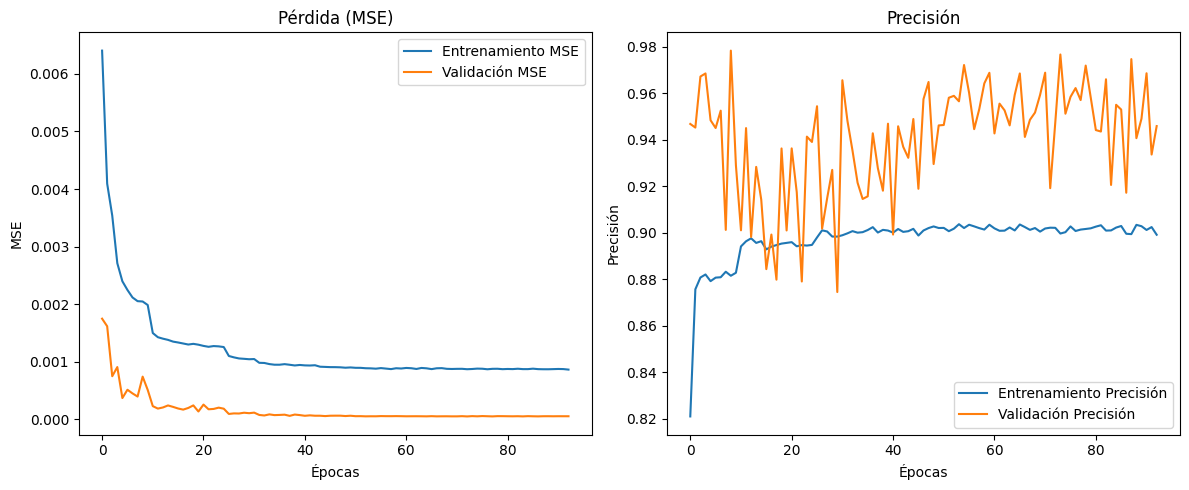

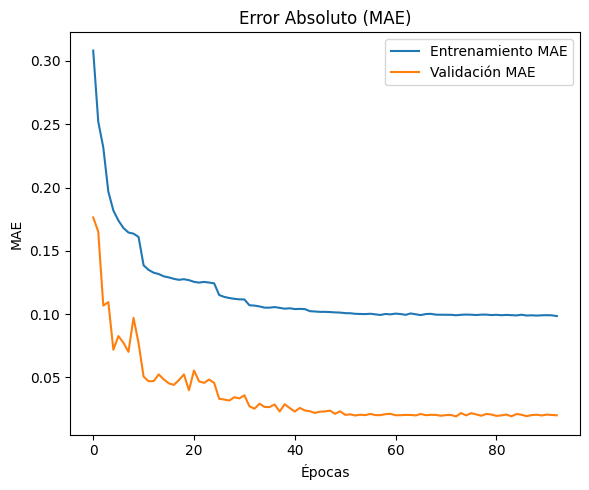

In [10]:
# 9. Visualización de las Métricas de Entrenamiento

def graficar_historial(train_losses, val_losses, train_precision_list, val_precision_list, train_mae_list, val_mae_list):
    plt.figure(figsize=(12, 5))

    # Pérdida (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Entrenamiento MSE')
    plt.plot(val_losses, label='Validación MSE')
    plt.title('Pérdida (MSE)')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(train_precision_list, label='Entrenamiento Precisión')
    plt.plot(val_precision_list, label='Validación Precisión')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Error Absoluto (MAE)
    plt.figure(figsize=(6, 5))
    plt.plot(train_mae_list, label='Entrenamiento MAE')
    plt.plot(val_mae_list, label='Validación MAE')
    plt.title('Error Absoluto (MAE)')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

graficar_historial(train_losses, val_losses, train_precision_list, val_precision_list, train_mae_list, val_mae_list)


In [11]:
# 10. Guardar el Modelo y el Escalador

# Guardar el modelo entrenado
torch.save(model.state_dict(), '../ia3/model/modelo_trastornos.pth')
print("\nModelo guardado exitosamente en 'modelo_trastornos.pth'")

# Guardar el escalador utilizando joblib
joblib.dump(scaler, '../ia3/scaler/scaler_trastornos_cognitivos.joblib')
print("Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'")


Modelo guardado exitosamente en 'modelo_trastornos.pth'
Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'
